# Visualizing Separation Analysis

**Gregory Way 2019**

Visualizing GTEx Sex and TARGET MYCN Status Features

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))

Warning message:
“package ‘dplyr’ was built under R version 3.4.4”Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”Warning message:
“package ‘cowplot’ was built under R version 3.4.4”

In [2]:
# Store t test results and identify top features
t_test_results_files <- list.files("results", full.names = TRUE)

best_result_list <- list()
line_gg_list <- list()
for (t_test_file in t_test_results_files) {
  full_results_df <- readr::read_tsv(t_test_file,
                                     col_types = readr::cols(
                                       t_stat = readr::col_double(),
                                       t_p = readr::col_double(),
                                       algorithm = readr::col_character(),
                                       feature_num = readr::col_double(),
                                       z_dim = readr::col_double(),
                                       signal = readr::col_character(),
                                       seed = readr::col_double(),
                                       neg_log_p = readr::col_double()
                                       )
                                     )
  
  top_results_df <- full_results_df %>%
    dplyr::group_by(algorithm, z_dim, signal) %>%
    dplyr::filter(neg_log_p == max(neg_log_p),
                  signal == "signal")
  
  # Create factors for plotting
  top_results_df$z_dim <-
    factor(top_results_df$z_dim,
           levels =
             sort(as.numeric(paste(unique(top_results_df$z_dim))))
    )
  
  top_results_df$algorithm <-
    factor(top_results_df$algorithm,
           levels = c("pca", "ica", "nmf", "dae", "vae"))
  
  panel_gg <- ggplot(top_results_df,
                       aes(x = z_dim,
                           y = neg_log_p,
                           color = algorithm,
                           group = algorithm)) +
    geom_smooth(aes(fill = algorithm),
                lwd = 0.3,
                alpha = 0.4,
                method = 'loess',
                formula = 'y ~ x') +
    geom_point(size = 0.5) +
    scale_color_manual(name = "Algorithm",
                       values = c("#e41a1c",
                                  "#377eb8",
                                  "#4daf4a",
                                  "#984ea3",
                                  "#ff7f00"),
                       labels = c("pca" = "PCA",
                                  "ica" = "ICA",
                                  "nmf" = "NMF",
                                  "dae" = "DAE",
                                  "vae" = "VAE")) +
    scale_fill_manual(name = "Algorithm",
                      values = c("#e41a1c",
                                 "#377eb8",
                                 "#4daf4a",
                                 "#984ea3",
                                 "#ff7f00"),
                      labels = c("pca" = "PCA",
                                 "ica" = "ICA",
                                 "nmf" = "NMF",
                                 "dae" = "DAE",
                                 "vae" = "VAE")) +
    theme_bw() +
    ylab("-log10 P Value") +
    xlab("k Dimensions") +
    theme(axis.title.x = element_text(size = 8),
          axis.title.y = element_text(size = 8),
          axis.text.x = element_text(angle = 90, size = 5),
          axis.text.y = element_text(size = 7),
          plot.title = element_text(size = 9,
                                    hjust = 0.5),
          legend.text = element_text(size = 7),
          legend.title = element_text(size = 8),
          legend.key.size = unit(0.7, "lines"))
  
  
  best_result_df <- top_results_df %>%
    dplyr::arrange(desc(neg_log_p)) %>%
    dplyr::ungroup() %>%
    dplyr::top_n(n = 1, wt = neg_log_p)
  
  best_result_list[[t_test_file]] <- best_result_df
  line_gg_list[[t_test_file]] <- panel_gg
}

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

## Plot GTEx Sex Example

In [3]:
file <- file.path("..", "0.expression-download", "download", "GTEx_v7_Annotations_SubjectPhenotypesDS.txt")
gtex_pheno_df <- readr::read_tsv(file)

Parsed with column specification:
cols(
  SUBJID = col_character(),
  SEX = col_double(),
  AGE = col_character(),
  DTHHRDY = col_double()
)


In [4]:
best_k_dim <- paste(best_result_list[[t_test_results_files[2]]]$z_dim)
best_seed <- paste(best_result_list[[t_test_results_files[2]]]$seed)
best_feature <- paste0(paste(best_result_list[[t_test_results_files[2]]]$algorithm),
                       "_", 
                       paste(best_result_list[[t_test_results_files[2]]]$feature_num))

In [5]:
feature_file <- file.path("..",
                          "2.sequential-compression",
                          "results",
                          "GTEX_results",
                          "ensemble_z_matrices",
                          paste0("gtex_components_", best_k_dim),
                          paste0("model_", best_seed, "_z_matrix.tsv.gz"))

top_feature_df <- readr::read_tsv(feature_file,
                                  col_types = readr::cols(
                                    .default = readr::col_double(),
                                    sample_id = readr::col_character()
                                  )
) %>%
  dplyr::select(sample_id, !!best_feature)

In [6]:
full_gtex_ids <- c()
for (gtex_id in strsplit(top_feature_df$sample_id, "-")) {
  gtex_id_unlist <- unlist(gtex_id)
  sample_id <- paste0(gtex_id_unlist[1], "-", gtex_id_unlist[2])
  full_gtex_ids <- c(full_gtex_ids, sample_id)
}

top_feature_df$gtex_id <- full_gtex_ids
top_feature_df <- top_feature_df %>%
  dplyr::left_join(gtex_pheno_df, by = c("gtex_id" = "SUBJID"))

top_feature_df$SEX <- dplyr::recode_factor(top_feature_df$SEX, `1` = "Male", `2` = "Female")
top_feature_df$SEX <- factor(top_feature_df$SEX, levels = c("Female", "Male"))

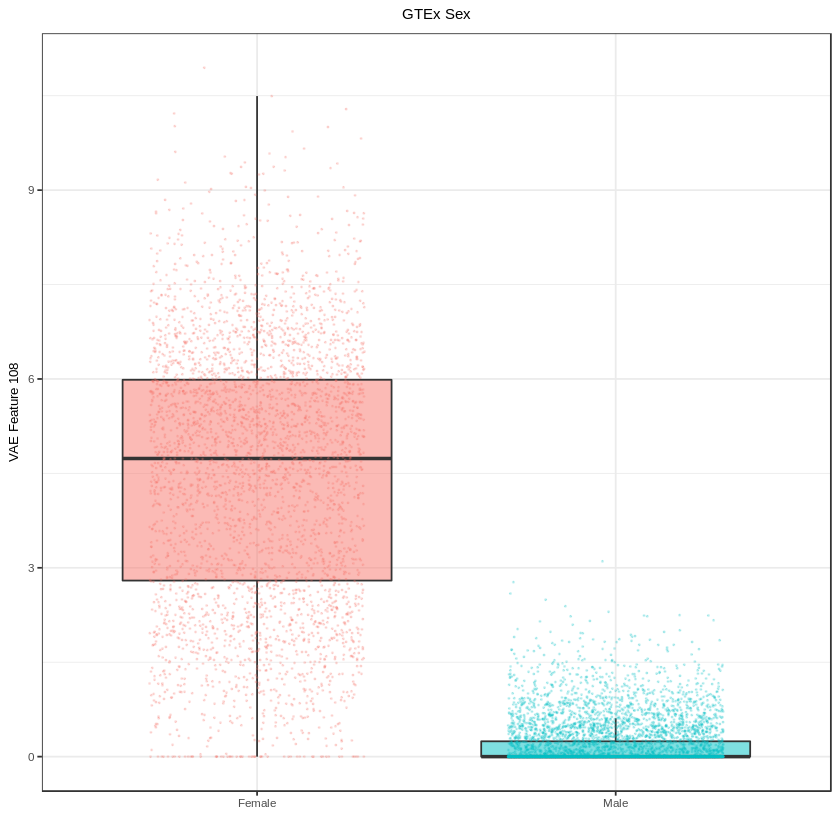

In [7]:
gtex_sex_gg <- ggplot(top_feature_df,
                      aes(y = vae_108,
                          x = SEX,
                          fill = SEX)) +
  geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
  geom_jitter(aes(color = SEX),
              size = 0.2,
              alpha = 0.2,
              width = 0.3) +
  theme_bw() +
  ylab("VAE Feature 108") +
  xlab("") +
  ggtitle("GTEx Sex") +
  theme(axis.title.x = element_text(size = 8),
        axis.title.y = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        axis.text.y = element_text(size = 7),
        plot.title = element_text(size = 9,
                                  hjust = 0.5),
        legend.position = "none")

gtex_sex_gg

## Plot TARGET MYCN Amplification Results

In [8]:
best_k_dim <- paste(best_result_list[[t_test_results_files[1]]]$z_dim)
best_seed <- paste(best_result_list[[t_test_results_files[1]]]$seed)
best_feature <- paste0(paste(best_result_list[[t_test_results_files[1]]]$algorithm),
                       "_", 
                       paste(best_result_list[[t_test_results_files[1]]]$feature_num))

In [9]:
feature_file <- file.path("..",
                          "2.sequential-compression",
                          "results",
                          "TARGET_results",
                          "ensemble_z_matrices",
                          paste0("target_components_", best_k_dim),
                          paste0("model_", best_seed, "_z_matrix.tsv.gz"))

top_feature_df <- readr::read_tsv(feature_file,
                                  col_types = readr::cols(
                                    .default = readr::col_double(),
                                    sample_id = readr::col_character()
                                    )
                                  ) %>%
  dplyr::select(sample_id, !!best_feature)

In [10]:
# Load TARGET phenotype data
file <- file.path("..", "0.expression-download", "data", "2017-09-30-TARGET update harmonized.txt")
nbl_pheno_df <- readr::read_tsv(file)

full_target_ids <- c()
for (target_id in strsplit(top_feature_df$sample_id, "-")) {
  target_id_unlist <- unlist(target_id)
  full_target_ids <- c(full_target_ids, target_id_unlist[3])
}

top_feature_df$target_id <- full_target_ids
top_feature_df <- top_feature_df %>% 
  dplyr::inner_join(nbl_pheno_df, by = c("target_id" = "usi"))

Parsed with column specification:
cols(
  .default = col_character(),
  `Age at Diagnosis in Days` = col_double(),
  `Event Free Survival Time in Days` = col_double(),
  `Overall Survival Time in Days` = col_double(),
  `Year of Diagnosis` = col_double(),
  `Year of Last Follow Up` = col_double(),
  `Ploidy Value` = col_double()
)
See spec(...) for full column specifications.


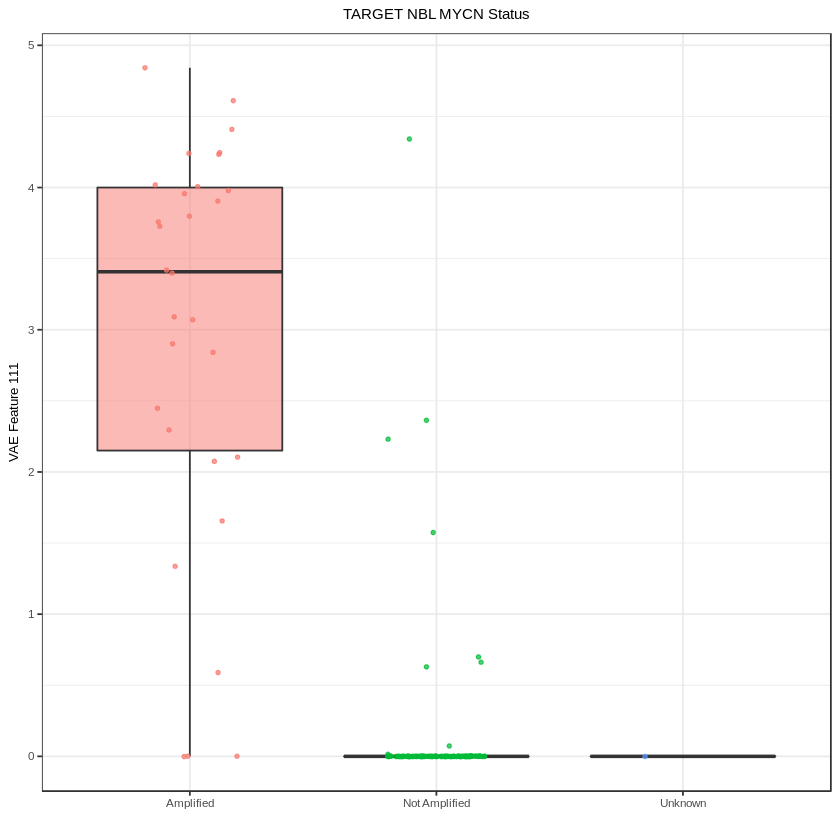

In [11]:
mycn_amp_gg <- ggplot(top_feature_df,
                      aes(y = vae_111,
                          x = `MYCN status`,
                          fill = `MYCN status`)) +
  geom_boxplot(alpha = 0.5,
               outlier.alpha = 0) +
  geom_jitter(aes(color = `MYCN status`),
              alpha = 0.7,
              size = 0.9,
              width = 0.2) +
  theme_bw() +
  ylab("VAE Feature 111") +
  xlab("") +
  ggtitle("TARGET NBL MYCN Status") +
  theme(axis.title.x = element_text(size = 8),
       axis.title.y = element_text(size = 8),
       axis.text.x = element_text(size = 7),
       axis.text.y = element_text(size = 7),
       plot.title = element_text(size = 9,
                                 hjust = 0.5),
       legend.position = "none")

mycn_amp_gg

## Compile Plot

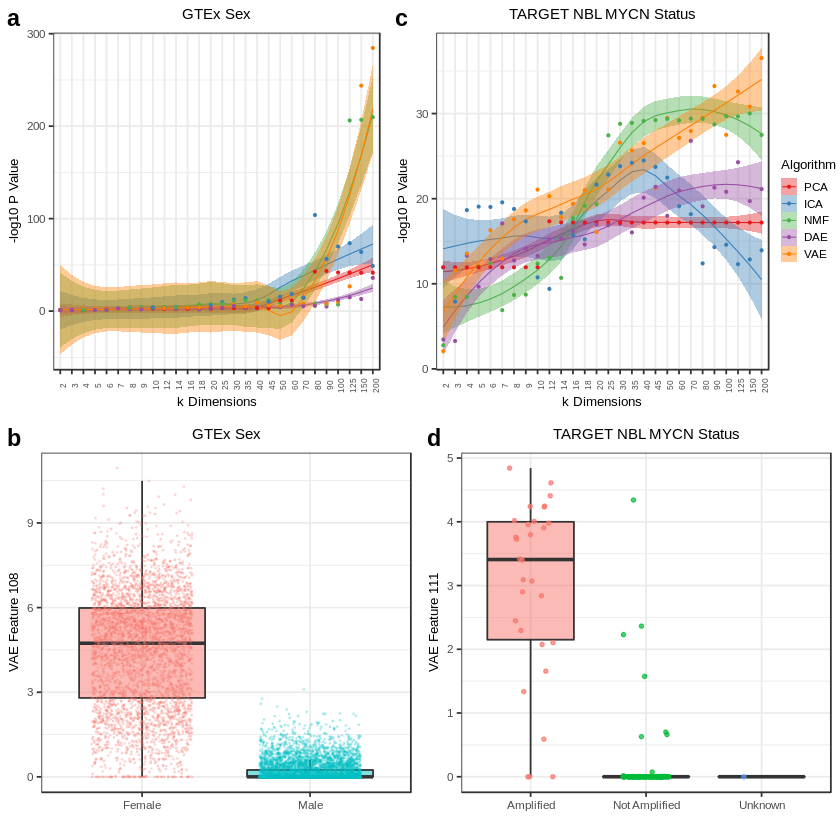

In [12]:
# Plot multi panel figure
line_gg_legend <- cowplot::get_legend(line_gg_list[[1]])
full_line_gg <- cowplot::plot_grid(
  line_gg_list[[2]] +
    theme(legend.position = "none") +
    ggtitle("GTEx Sex"),
  line_gg_list[[1]] +
    theme(legend.position = "none") +
    ggtitle("TARGET NBL MYCN Status"),
  labels = c("a", "c")
)

full_line_gg <- cowplot::plot_grid(full_line_gg,
                                   line_gg_legend,
                                   rel_widths = c(1, 0.08),
                                   ncol = 2)

box_gg <- cowplot::plot_grid(
  gtex_sex_gg,
  mycn_amp_gg,
  labels = c("b", "d"),
  ncol = 2
)

main_plot <- cowplot::plot_grid(
  full_line_gg,
  box_gg,
  nrow = 2
)

main_plot

In [13]:
for(extension in c('.png', '.pdf')) {
  fig_file <- paste0("target_mycn_gtex_sex_plot", extension)
  fig_file <- file.path("figures", fig_file)
  cowplot::save_plot(filename = fig_file,
                     plot = main_plot,
                     base_height = 140,
                     base_width = 160,
                     units = "mm")
}